# Imports and Settings

In [190]:
from matplotlib import pyplot as plt
import numpy as np
import math
import numba as nb

In [191]:
N_TIME_SAMPLES = 64
N_FREQUENCY_CHANNELS = 64 # Must be power of 2

# Upper bound of the FRB
UPPER_BOUND = np.random.random()*N_FREQUENCY_CHANNELS

# Lower bound of the FRB
LOWER_BOUND = np.random.random()*UPPER_BOUND

LOWER_BOUND = -1
UPPER_BOUND = N_FREQUENCY_CHANNELS

# RFI intensitiy will be in range [0, RFI_STRENGTH)
RFI_STRENGTH = 0

# FRB intensity will be in range [FRB_MIN_STRENGTH, FRB_MAX_STRENGTH)
FRB_MAX_STRENGTH = 10
FRB_MIN_STRENGTH = 10

# Experimental
ADD_FRB_NOISE = False
FRB_NOISE_STRENGTH = 0

EMPHASIZE = True
LOW_FILTER = True

LOW_FILTER_MAX = 5

# Create Data
## Create the data with the background noise

In [192]:
data = np.random.random( (N_FREQUENCY_CHANNELS, N_TIME_SAMPLES) )*RFI_STRENGTH

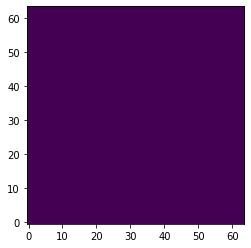

In [193]:
plt.imshow(data, origin="lower")
plt.show()

## Draw a line in the data

In [194]:
# Draws a line in the data given the lines slope and y incercept
def draw_line(data, m, b):
    f = lambda x: m*x + b

    # For every x value, fill in y values
    for x in range(N_TIME_SAMPLES):
        draw_back(data, m, b, x, f(x), x+1, f(x+1))
    
    return data

In [195]:
def draw_back(data, m, b, x0, y0, x1, y1):
    f_inv = lambda y: (y-b)/m

    # Modified Bresenham's line algorithm 
    while y0 <= y1 and f_inv(y1) < N_TIME_SAMPLES:
        err = x1 - f_inv(y0)-0.5
        val = np.random.random()*(FRB_MAX_STRENGTH-FRB_MIN_STRENGTH) + FRB_MIN_STRENGTH

        if err > 0 and y0 < UPPER_BOUND and y0 > LOWER_BOUND:
            data[int(y0)][x0] = val
        elif y0 < UPPER_BOUND and y0 > LOWER_BOUND:
            data[int(y0)][x1] = val

        if y0 < UPPER_BOUND and y0 > LOWER_BOUND and ADD_FRB_NOISE:
            amt = np.random.random() * FRB_NOISE_STRENGTH
            for i in range(int(-amt/2), int(amt/2)):
                data[int(y0)][x1-i] = np.random.random()*(FRB_MAX_STRENGTH-FRB_MIN_STRENGTH) + FRB_MIN_STRENGTH
        
        y0 += 1

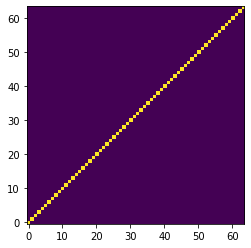

In [196]:
m = math.tan(np.random.random()*math.pi/4 + math.pi/4) # Choose a ranom slope in range [PI/4, PI/2)
x_intercept = np.random.random()*N_TIME_SAMPLES # Choose a random x intercept in range [0, N_SAMPLES)

b = -m*x_intercept # Calculate the y intercept

m = 1
b = 0

data = draw_line(data, m, b) # Draw the line

plt.imshow(data, origin="lower")
plt.show()

# FRB Detection

In [197]:
@nb.jit(nopython=True, parallel=True)
def filter(data):
    n =  ( N_FREQUENCY_CHANNELS*FRB_MAX_STRENGTH )**7

    for x in range( N_TIME_SAMPLES ):
        for y in range( N_FREQUENCY_CHANNELS ):
            if LOW_FILTER and data[y][x] <= LOW_FILTER_MAX:
                data[y][x] = 0
            elif EMPHASIZE:
                data[y][x] = data[y][x]**10 / n
    
    return data
    
def line_detection(data):
    points = []
    i = 0 # The current iteration
    while N_FREQUENCY_CHANNELS / 2**i > 1:
        r = int(N_FREQUENCY_CHANNELS / 2**i)
        for j in range(2**i):
            for x in range(N_TIME_SAMPLES):
                temp = np.zeros( (r,) )
                temp[0:int(r/2)] = data[j*r:(j+1)*r:2, x] + data[j*r+1:(j+1)*r+1:2, x]

                if( x < N_TIME_SAMPLES-1 ):
                    pass
                    temp[int(r/2):r] = data[j*r:(j+1)*r:2, x] + data[j*r+1:(j+1)*r+1:2, x+1]
                    # temp[int(r/2):r] = data[0:r:2, x] + data[1:r+1:2, x]

                data[r*j:r*(j+1), x] = temp

        plt.imshow(data, origin="lower")
        plt.show()
        i += 1
    
    return data

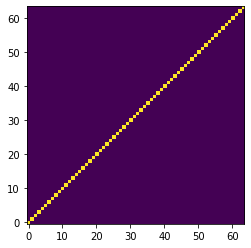

In [198]:
# data = filter(data)
plt.imshow(data, origin="lower")
plt.show()

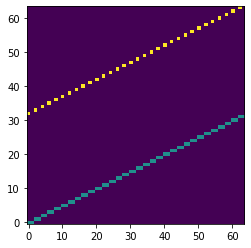

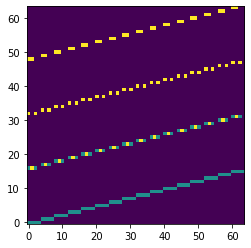

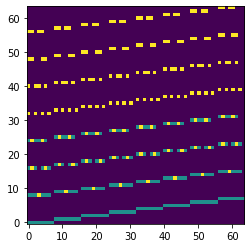

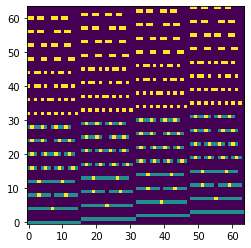

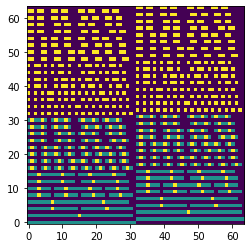

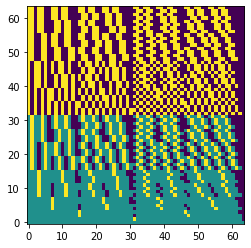

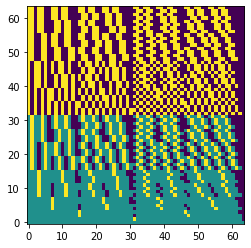

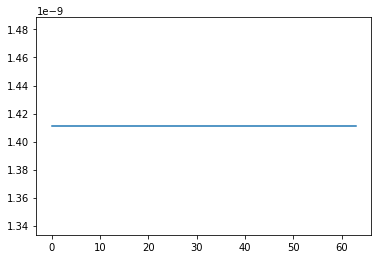

In [199]:
sums = line_detection(data)

plt.imshow(sums, origin="lower")
plt.show()

plt.plot(sums[0])
plt.show()

sums = sums[0]

In [200]:
print(LOWER_BOUND, UPPER_BOUND)

-1 64
